# Decision Tree - Heart Disease Predictions

In this notebook we will use decision trees to predict whether someone has heart disease or not. 

We will focus on using scikit-learn to build a classification tree. We will also explore concepts such as cost complexity pruning to refine predictive powers of decision trees.

## 1. Import Modules and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

For this notebook we will use the <a href="https://archive.ics.uci.edu/ml/datasets/heart+disease" >Heart Disease Dataset from the UCI Machine Learning Repository</a>, where we will predict whether someone has heart disease or not based on their gender, age and other metrics. 

In [2]:
df = pd.read_csv("processed.cleveland.data", header=None)

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


The labels and their detailed explanation can be found on the UCI Machine Learning Repository, here we attach the column names to the data.

In [4]:
df.columns = ['age', 
             'sex',
             'cp',
             'restpb',
             'chol',
             'fbs',
             'restecg',
             'thalach',
             'exang',
             'oldpeak',
             'slope',
             'ca',
             'thal',
             'hd']
df.head()

,age,sex,cp,restpb,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


## 2. Data Exploration, Cleaning and Wrangling

After loading the data, the first step is always to get an idea of what the data looks like and how it's structured. That should give us an idea on how to clean it, as well as what models to use. 

In [5]:
df.dtypes

age        float64
sex        float64
cp         float64
restpb     float64
chol       float64
fbs        float64
restecg    float64
thalach    float64
exang      float64
oldpeak    float64
slope      float64
ca          object
thal        object
hd           int64
dtype: object

## Dealing with missing data

Some entries are incomplete, and are marked with `?`. To facilitate downstream analysis, we have to find and deal with the missing data. 

In [6]:
df['ca'].unique()

array(['0.0', '3.0', '2.0', '1.0', '?'], dtype=object)

In [7]:
df['thal'].unique()

array(['6.0', '3.0', '7.0', '?'], dtype=object)

In [8]:
df.loc[(df['ca'] == '?') | (df['thal'] == '?')]

,age,sex,cp,restpb,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
87,53.0,0.0,3.0,128.0,216.0,0.0,2.0,115.0,0.0,0.0,1.0,0.0,?,0
166,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,?,3.0,0
192,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,?,7.0,1
266,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,?,2
287,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,?,7.0,0
302,38.0,1.0,3.0,138.0,175.0,0.0,0.0,173.0,0.0,0.0,1.0,?,3.0,0


The number of entries with missing data is not too high, so we can just remove them. 

In [9]:
df_no_missing = df.loc[(df['ca'] != '?') & (df['thal'] != '?')]

---

## Split data into dependent and independent variables

In [10]:
X = df_no_missing.drop('hd', axis=1).copy()
y = df_no_missing['hd']

---

## One-hot encoding

Some metrics are categorical, and one of the most oommon ways to deal with them is with one-hot encoding.

In [11]:
X_encoded = pd.get_dummies(X, columns=['cp',
                                      'restecg',
                                      'slope',
                                      'thal'])
X_encoded.head()

,age,sex,restpb,chol,fbs,thalach,exang,oldpeak,ca,cp_1.0,...,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,slope_1.0,slope_2.0,slope_3.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,0.0,1,...,0,0,0,1,0,0,1,0,1,0
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,3.0,0,...,1,0,0,1,0,1,0,1,0,0
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,0,...,1,0,0,1,0,1,0,0,0,1
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,0.0,0,...,0,1,0,0,0,0,1,1,0,0
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,0.0,0,...,0,0,0,1,1,0,0,1,0,0


Since we are only interested in binary classification, i.e. whether someone has heart disease or not, but not the severity of heart disease, we can convert all non-zero labels to one. 

In [12]:
y[y > 0] = 1 ## Set all values bigger than 0 to 1 since we are only intereseted in binary classification
y.unique()

<ipython-input-12-57714ab1fe59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y > 0] = 1 ## Set all values bigger than 0 to 1 since we are only intereseted in binary classification
C:\Users\xf20985\Anaconda3\lib\site-packages\pandas\core\series.py:1020: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)


array([0, 1], dtype=int64)

## 3. Build a preliminary Classification Tree

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42)

In [14]:
clf_dt = DecisionTreeClassifier(random_state=42)
clf_dt = clf_dt.fit(X_train, y_train)

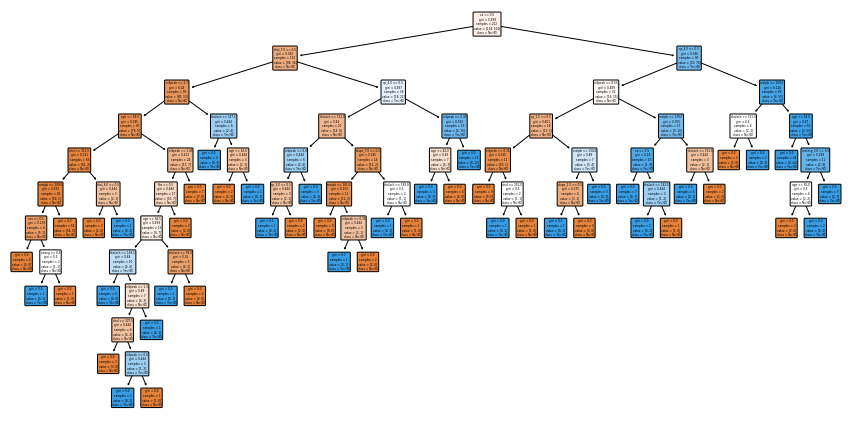

In [15]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
         filled=True,
         rounded=True,
         class_names=["No HD", "Yes HD"],
         feature_names=X_encoded.columns);

We are not really interested in what the decision criteria is in each individual node, we are more interested in the depth and complexity of the entire tree (big picture!). As with other machine learning methods, highly complex trees may fit the training data very well, but perform poorly with testing data (overfitting). 

Confusion Matrix is a excellent and intuitive way to visualise classification data. It plots the true and predictive labels for each class.

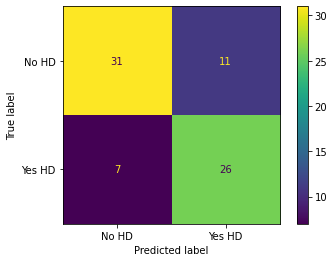

In [16]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["No HD", "Yes HD"])
plt.show()

It seems quite a significant portion 

$\dfrac{11}{31 + 11}$ ~ 26%

of subjects who do not have heart disease are misclassified in the testing set.

And 

$\dfrac{7}{7 + 26}$ ~ 21% 

who has heart disease were missed by the model's predictions.

## 4. Cost Complexity Tree-pruning

Put plainly, pruning is the action of selectively removing certain parts of a trees to promote its growth. Reducing the number of leaf nodes may result in slightly worse training accuracy, but greatly improve testing performance. Alpha is a pruning parameter, and the higher the alpha, the more nodes will be pruned.

In [17]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train) # Determine values for alpha
ccp_alphas = path.ccp_alphas                                 # extract different values for alpha
ccp_alphas = ccp_alphas[:-1]                                 # Exclude the maximum values

In [18]:
clf_dts = []   ## Create an array to put decision trees in

In [19]:
## Create one decision tree per alpha and store in array
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf_dt.fit(X_train, y_train)
    clf_dts.append(clf_dt)

In [20]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

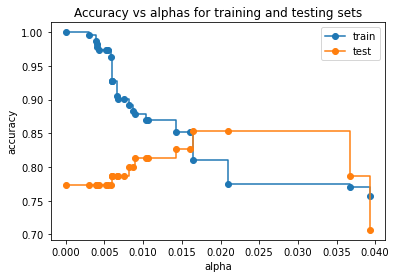

In [21]:
fig, ax = plt.subplots()
ax.set_xlabel('alpha')
ax.set_ylabel('accuracy')
ax.set_title('Accuracy vs alphas for training and testing sets')
ax.plot(ccp_alphas, train_scores, marker='o', label='train', drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label='test', drawstyle="steps-post")
ax.legend()
plt.show()

Looking at the graph, a good value for alpha might be 0.016 as the tesing accuracy is the highest at this value.

## Cross Validation for Best Alpha

However, there are many ways data can be split into training and testing sets. To find the best alphas in general, we can use cross validation.

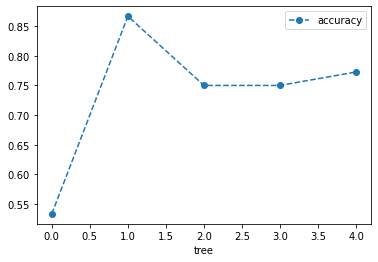

In [23]:
clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=0.016)

scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
df = pd.DataFrame(data={'tree': range(5), 'accuracy': scores})
df.plot(x='tree', y='accuracy', marker='o', linestyle='--')
plt.show()

The accuracy was high at one of the splits, but it may not the best over all possible splits. Using different training and testing datasets with the same alpha resulted in different accuracies, suggesting that alpha is sensitive to datasets. 

Here we find the best alphas over different possible splits with cross validations. 

<AxesSubplot:xlabel='alpha'>

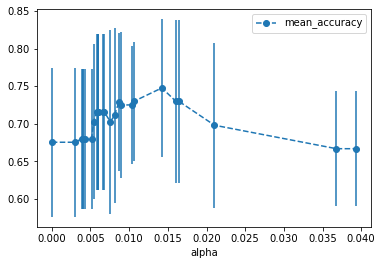

In [24]:
alpha_loop_values = []
for ccp_alpha in ccp_alphas:
    clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    scores = cross_val_score(clf_dt, X_train, y_train, cv=5)
    alpha_loop_values.append([ccp_alpha, np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                            columns=['alpha', 'mean_accuracy', 'std'])
alpha_results.plot(x='alpha', y='mean_accuracy', yerr='std', marker='o', linestyle='--')

In [25]:
best_alpha = alpha_results.iloc[alpha_results['mean_accuracy'].idxmax(),]['alpha']

## Evaluating final tree

In [26]:
clf_dt_pruned = DecisionTreeClassifier(random_state=42, ccp_alpha=best_alpha)
clf_dt_pruned.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.014224751066856332, random_state=42)

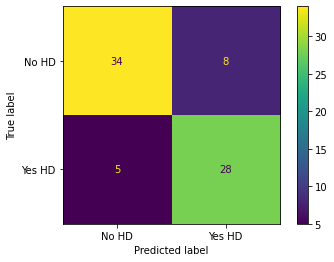

In [29]:
plot_confusion_matrix(clf_dt_pruned,
                     X_test,
                     y_test,
                     display_labels=["No HD", "Yes HD"])

The accuracy improved significantly for the testing set. 

The percentage of people without heart disease that were misclassified is now 

$\dfrac{8}{34 + 8}$ ~ 19%

And those with heart disease that were missed is now 

$\dfrac{5}{5 + 28}$ ~ 15%

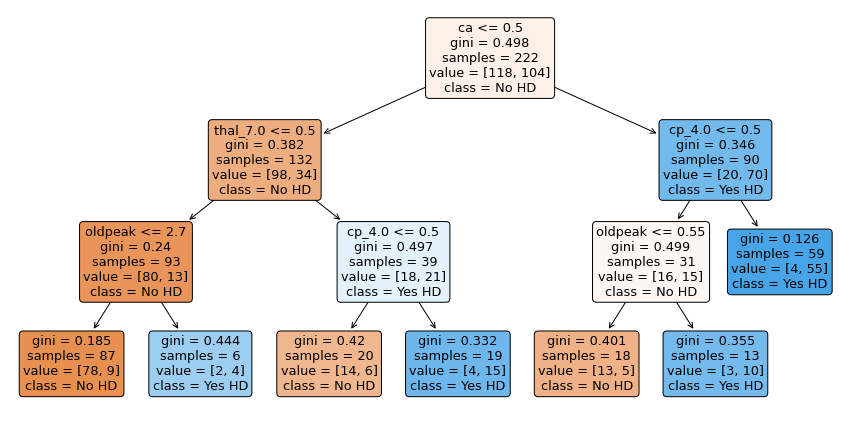

In [28]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt_pruned, 
         filled=True,
         rounded=True,
         class_names=["No HD", "Yes HD"],
         feature_names=X_encoded.columns);

The final tree has far fewer nodes than the original tree and is much more lean, and more importantly, it leads to better performance. 